In [1]:
import geopandas as gpd
from rasterstats import zonal_stats
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.cm as cm
from matplotlib.colors import ListedColormap, BoundaryNorm
import pandas as pd
import matplotlib.patheffects as path_effects
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
import fiona
from shapely.geometry import Point, box, Polygon
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.ticker import FuncFormatter, FixedLocator
from matplotlib.patches import FancyArrowPatch
from matplotlib.ticker import MultipleLocator
import contextily as cx
from matplotlib_scalebar.scalebar import ScaleBar
import squarify
from matplotlib.patches import Rectangle
from matplotlib.patches import FancyBboxPatch
import matplotlib.patheffects as pe
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

In [30]:
LGAS = gpd.read_file("NVP_Locations/VIC_SA_LGAS_NVP.gpkg")
shapefile = gpd.read_file("Aus_Shapefile/STE_2021_AUST_GDA2020.shp")
colac_lin = gpd.read_file("NVP_Locations/colac_lineament.gpkg")
PDmatrix = gpd.read_file("NVP_Locations/P_D_matrix.gpkg")
WP = gpd.read_file("NVP_Locations/Western_Plains_Merged.gpkg")
CH = gpd.read_file("NVP_Locations/subProvincesAndRegions.gdb", layer="CentralHighlands")
MG = gpd.read_file("NVP_Locations/subProvincesAndRegions.gdb", layer="MtGambierProvince")
faults = gpd.read_file("NVP_Locations/NVP_Faults.gpkg")

In [31]:
PDmatrix = PDmatrix.to_crs(LGAS.crs)
colac_lin = colac_lin.to_crs(LGAS.crs)
shapefile = shapefile.to_crs(LGAS.crs)
WP = WP.to_crs(LGAS.crs)
CH = CH.to_crs(LGAS.crs)
MG = MG.to_crs(LGAS.crs)
faults = faults.to_crs(LGAS.crs)

In [32]:
faults_proxy = Line2D([], [], linestyle='-', color='gray', linewidth=4, label='Faults')
pd_proxy = Line2D([], [], marker='^', linestyle='None', color='orange',
                    markerfacecolor='orange', markeredgecolor='#910101', markersize=8, label='Eruptive Centres')
WP_proxy = Patch(facecolor='#0115be', edgecolor='#000892', label='Western Plains Subprovince')
CH_proxy = Patch(facecolor='#ef78ff', edgecolor='#b102c9', label='Central Highlands Subprovince')
MG_proxy = Patch(facecolor='#54ff14', edgecolor='#2da600', label='Mt Gambier Subprovince')
City_proxy = Line2D([], [], marker='*', linestyle='None', color='black',
                    markerfacecolor='white', markeredgecolor='black', markersize=14, label='Major Centres')
Regional_proxy = Line2D([], [], marker='*', linestyle='None', color='black',
                    markerfacecolor='#03f8fc', markeredgecolor='black', markersize=10, label='Regional Towns')

handles1 = [WP_proxy, CH_proxy, MG_proxy]
labels1  = [h.get_label() for h in handles1]

handles2 = [faults_proxy, pd_proxy, City_proxy, Regional_proxy]
labels2  = [h.get_label() for h in handles2]

In [24]:
def Victoria_Labels(ax, title=None, xlim=(140, 145.5), ylim=(-39, -36.5), aspect=4/3):

    ax.scatter(144.97806, -37.8240, facecolor='white', edgecolor='black', zorder=4, marker='*',  s=110) #Melbourne
    ax.scatter(140.78377, -37.82668, facecolor='white', edgecolor='black', zorder=3, marker='*',  s=110)
    ax.scatter(142.4778, -38.3721, color='#03f8fc', edgecolor='black', zorder=4, s=70, marker='*')
    ax.scatter(144.3598, -38.1493, color='#03f8fc', edgecolor='black', zorder=4, s=70, marker='*')
    ax.scatter(143.8503, -37.5622, color='#03f8fc', edgecolor='black', zorder=4, s=70, marker='*')
    ax.scatter(144.2786, -36.7596, color='#03f8fc', edgecolor='black', zorder=4, s=70, marker='*')


    melbourne = ax.annotate(
        'Melbourne',  
        xy=(144.97806, -36.7240),
        xytext=(145.1, -37.75),
        fontsize=8,
        color='black',
        ha="center",
        zorder=7
    )
    melbourne.set_path_effects([
        path_effects.Stroke(linewidth=3, foreground="white"),
        path_effects.Normal()
    ])
    
    mt_gambier = ax.annotate(
        "Mt Gambier",
        xy=(140.7659, -37.8414),
        xytext=(140.7, -37.75),
        fontsize=8,
        color="black",
        zorder=7
    )
    mt_gambier.set_path_effects([
        path_effects.Stroke(linewidth=3, foreground="white"),
        path_effects.Normal()
    ])

    sa = ax.annotate(
        "South Australia",
        xy=(140.6, -37.0648),
        xytext=(140.76, -37.33),
        rotation=270,
        fontsize=11,
        color='grey',
        zorder=7
    )
    sa.set_path_effects([
        path_effects.Stroke(linewidth=3, foreground="white"),
        path_effects.Normal()
    ])

    vic = ax.annotate(
        "Victoria",
        xy=(140.2, -37.0648),
        xytext=(141.04, -37.14),
        rotation=90,
        fontsize=11,
        color='grey',
        zorder=7
    )
    vic.set_path_effects([
        path_effects.Stroke(linewidth=3, foreground="white"),
        path_effects.Normal()
    ])

    colac = ax.annotate(
        "Colac Lineament",
        xy=(140.7659, -37.8414),
        xytext=(141.52, -38.7),
        fontsize=9,
        rotation=8.5,
        color="black",
        zorder=4
    )
    colac.set_path_effects([
        path_effects.Stroke(linewidth=3, foreground="white"),
        path_effects.Normal()
    ])




    ax.set_facecolor('#e0f4ff')
    if title:
        ax.set_title(title, fontsize=16)
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.set_aspect(aspect, adjustable='box')
    
    

In [25]:
def add_north_arrow(ax, loc=(0.1, 0.9), length=0.08, 
                    head_width=0.03, head_length=0.03, 
                    pad=0.0, text_offset=0.02, **text_kwargs):

    x0, y0 = loc

    arrow = FancyArrowPatch(
        (x0, y0 - length + pad), (x0, y0 - pad),
        transform=ax.transAxes,
        arrowstyle=f'-|>,head_width={head_width},head_length={head_length}',
        linewidth=1,
        color=text_kwargs.get('color','black')
    )
    ax.add_artist(arrow)

    ax.text(
        x0, y0 + text_offset,
        'N',
        transform=ax.transAxes,
        ha='center',
        va='bottom',
        **text_kwargs
    )

In [26]:
xmin, xmax = 140, 145.5
ymin, ymax = -39, -36.5


extent_poly = Polygon([
    (xmin, ymin),
    (xmax, ymin),
    (xmax, ymax),
    (xmin, ymax),
    (xmin, ymin)
])
nvp_extent = gpd.GeoDataFrame(
    {"geometry": [extent_poly]},
    crs="EPSG:4326"
)

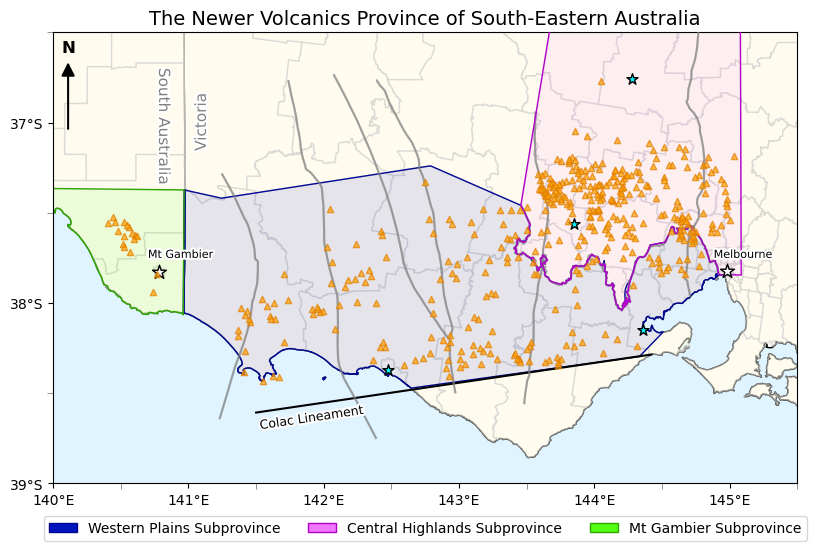

In [33]:
fig, ax = plt.subplots(figsize=(8, 6))

colac_lin.plot(ax=ax, color='black', zorder=3)
LGAS.plot(ax=ax,color='#fffbe0', edgecolor='#CCCCCC', zorder=1, alpha=0.5)
shapefile.plot(ax=ax, color='white',edgecolor='black', zorder=0)
WP.plot(ax=ax, color='#0115be', edgecolor='#000892', alpha=0.1, zorder=2)
CH.plot(ax=ax, color='#ef78ff', edgecolor='#b102c9', alpha=0.1, zorder=2)
MG.plot(ax=ax, color='#54ff14', edgecolor='#2da600', alpha=0.1, zorder=2)
WP.plot(ax=ax, facecolor='none', edgecolor='#000892',  zorder=2)
CH.plot(ax=ax, facecolor='none', edgecolor='#b102c9', zorder=4)
MG.plot(ax=ax, facecolor='none', edgecolor='#2da600',  zorder=2)
faults.plot(ax=ax, color='gray', alpha=0.5, zorder=3)
PDmatrix.plot(ax=ax, color='orange', edgecolor='#e17d00', marker='^', markersize=20, zorder=5, alpha=0.7)


ax.legend(handles=handles1, frameon=True,loc='center',bbox_to_anchor=(0.5,-0.1), ncol=3)
ax.set_title("The Newer Volcanics Province of South-Eastern Australia", fontsize=14)
ax.set_facecolor('#e0f4ff')
ax.set_xlim(140, 145.5)
ax.set_ylim(-39,-36.5)
ax.set_aspect(4/3, adjustable='box')
fig.subplots_adjust(
    top   = 0.95,
    bottom= 0.10,
    left  = 0.05,
    right = 0.98
)
ax.annotate(
    '', 
    xy=(0.02, 0.94), 
    xytext=(0.02, 0.78),
    xycoords='axes fraction',
    arrowprops=dict(
        arrowstyle='-|>',
        mutation_scale=20,
        lw=1.5,
        color='black'
    )
)


ax.text(
    0.02, 0.95,
    'N',
    transform=ax.transAxes,
    ha='center',
    va='bottom',
    fontsize=12,
    fontweight='bold',
    color='black'
)

xticks = np.arange(141, 146)   
yticks = np.arange(-39, -36.4, 0.5)       

ax.set_xticks(xticks)
ax.set_yticks(yticks)


def lon_formatter(x, pos):
    return f"{int(x)}°E"

def lat_formatter(y, pos):
    deg = abs(y)
    if deg.is_integer():
        return f"{int(deg)}°S"
    else:
        return f"{deg:.1f}°S"

#Y-Axis
ax.yaxis.set_major_formatter(FuncFormatter(lat_formatter))
ax.yaxis.set_major_locator(MultipleLocator(1.0))
ax.yaxis.set_minor_locator(MultipleLocator(0.5))
ax.tick_params(axis='y', which='minor', length=4, color='gray')
ax.yaxis.set_major_formatter(FuncFormatter(lat_formatter))

#X-Axis
ax.xaxis.set_major_locator(MultipleLocator(1.0))
ax.xaxis.set_minor_locator(MultipleLocator(0.5))
ax.tick_params(axis='x', which='minor', length=4, color='gray')
ax.xaxis.set_major_formatter(FuncFormatter(lon_formatter))

Victoria_Labels(ax)

plt.savefig(
    "DataMap_Outputs/Thesis_Map_NVP.png",
    dpi=600,
    bbox_inches='tight',
    pad_inches=0.1         
)


## Melbourne CBD

In [9]:
gdf = gpd.read_file("Aus_Shapefile/Melbourne/UCL_2021_AUST_GDA2020.shp")
gboundary = gdf[gdf["UCL_NAME21"] == "Melbourne"]
mboundary = gpd.read_file("Aus_Shapefile/municipal-boundary.geojson")

In [10]:
gboundary_proxy = Patch(facecolor='pink', edgecolor='black', label='Urban Centre of Greater Melbourne')
melbhandles = [gboundary_proxy, pd_proxy]

In [11]:
def Victoria_subLabels(ax, title=None, xlim=(140, 145.5), ylim=(-39, -36.5), aspect=4/3):

    ax.scatter(144.97806, -37.8240, facecolor='white', edgecolor='black',marker='*', zorder=3, s=110)
    ax.scatter(140.78377, -37.82668, facecolor='white', edgecolor='black',marker='*', zorder=3, s=110)
    ax.scatter(142.4778, -38.3721, color='#03f8fc', edgecolor='black', zorder=6, s=90, marker='*')
    ax.scatter(144.3598, -38.1493, color='#03f8fc', edgecolor='black', zorder=6, s=90, marker='*')
    ax.scatter(143.8503, -37.5622, color='#03f8fc', edgecolor='black', zorder=6, s=90, marker='*')
    ax.scatter(144.2786, -36.7596, color='#03f8fc', edgecolor='black', zorder=6, s=90, marker='*')



    melbourne = ax.annotate(
        'Melbourne',  
        xy=(144.97806, -36.7240),
        xytext=(145.1, -37.75),
        fontsize=14,
        color='black',
        ha="center",
        zorder=7
    )
    melbourne.set_path_effects([
        path_effects.Stroke(linewidth=3, foreground="white"),
        path_effects.Normal()
    ])
    
    mt_gambier = ax.annotate(
        "Mt Gambier",
        xy=(140.7659, -37.8414),
        xytext=(140.7, -37.75),
        fontsize=14,
        color="black",
        zorder=10
    )
    mt_gambier.set_path_effects([
        path_effects.Stroke(linewidth=3, foreground="white"),
        path_effects.Normal()
    ])

    sa = ax.annotate(
        "South Australia",
        xy=(140.6, -37.0648),
        xytext=(140.76, -37.33),
        rotation=270,
        fontsize=18,
        color='grey',
        zorder=7
    )
    sa.set_path_effects([
        path_effects.Stroke(linewidth=3, foreground="white"),
        path_effects.Normal()
    ])

    vic = ax.annotate(
        "Victoria",
        xy=(140.2, -37.0648),
        xytext=(141.04, -37.14),
        rotation=90,
        fontsize=18,
        color='grey',
        zorder=7
    )
    vic.set_path_effects([
        path_effects.Stroke(linewidth=3, foreground="white"),
        path_effects.Normal()
    ])

    colac = ax.annotate(
        "Colac Lineament",
        xy=(140.7659, -37.8414),
        xytext=(141.52, -38.7),
        fontsize=14,
        rotation=8.5,
        color="black",
        zorder=4
    )
    colac.set_path_effects([
        path_effects.Stroke(linewidth=3, foreground="white"),
        path_effects.Normal()
    ])




    
    ax.set_facecolor('#e0f4ff')
    if title:
        ax.set_title(title, fontsize=16)
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.set_aspect(aspect, adjustable='box')
    
    

In [12]:
def Melbourne_Labels(ax, title=None, xlim=(140, 145.5), ylim=(-39, -36.5), aspect=4/3):
    melbourne = ax.annotate(
        'Melbourne',
        xy=(144.98, -37.81),
        xytext=(144.90, -37.82),
        fontsize=12,
        color='#1c1c1c',
        zorder=10,
        path_effects=[
            path_effects.Stroke(linewidth=3, foreground="#f2f0f0"),
            path_effects.Normal()
        ]
    )
    
    Sunbury = ax.annotate(
        'Sunbury',
        xy=(144.98, -37.81),
        xytext=(144.72, -37.57),
        fontsize=10,
        color='#1c1c1c',
        zorder=10,
        path_effects=[
            path_effects.Stroke(linewidth=3, foreground="#f2f0f0", alpha=0.8),
            path_effects.Normal()
        ]
    )
    
    Melton = ax.annotate(
        'Melton',
        xy=(144.98, -37.81),
        xytext=(144.559, -37.67),
        fontsize=10,
        color='#1c1c1c',
        zorder=10,
        path_effects=[
            path_effects.Stroke(linewidth=3, foreground="#f2f0f0", alpha=0.8),
            path_effects.Normal()
        ]
    )
    
    Craigieburn = ax.annotate(
        'Craigieburn',
        xy=(144.98, -37.81),
        xytext=(144.93, -37.59),
        fontsize=10,
        color='#1c1c1c',
        zorder=10,
        path_effects=[
            path_effects.Stroke(linewidth=3, foreground="#f2f0f0", alpha=0.8),
            path_effects.Normal()
        ]
    )
    Werribee = ax.annotate(
        'Werribee',
        xy=(144.98, -37.81),
        xytext=(144.63, -37.89),
        fontsize=10,
        color='#1c1c1c',
        zorder=10,
        path_effects=[
            path_effects.Stroke(linewidth=3, foreground="#f2f0f0", alpha=0.8),
            path_effects.Normal()
        ]
    )

In [13]:
def plot_Melbourne(ax):
    PDmatrix.plot(ax=ax, color='orange', edgecolor='#910101', marker='^', markersize=40, zorder=5)
    gboundary.plot(ax=ax, facecolor='pink', zorder=2, alpha=0.5)
    gboundary.plot(ax=ax, facecolor='none', edgecolor='black', linewidth=2, zorder=2, alpha=0.6)
    LGAS.plot(ax=ax,color='#fffbe0', edgecolor='#CCCCCC', zorder=1, alpha=0.5)
    shapefile.plot(ax=ax, color='white',edgecolor='black', zorder=0)
    
    ax.scatter(144.72, -37.58, color='white', edgecolor='black', zorder=4, s=50)
    ax.scatter(144.57, -37.685, color='white', edgecolor='black', zorder=4, s=50)
    ax.scatter(144.92, -37.59, color='white', edgecolor='black', zorder=4, s=50)
    ax.scatter(144.65, -37.9, color='white', edgecolor='black', zorder=4, s=50)
    

    ax.legend(handles=melbhandles, frameon=True,loc='center', fontsize=10,bbox_to_anchor=(0.5,-0.15), ncol=3)
    
    scalebar = ScaleBar(
        dx=111_120,
        units="m",
        length_fraction=0.2,
        location="upper right",
        box_alpha=0.6
    )
    ax.add_artist(scalebar)
    Melbourne_Labels(ax)
    
    ax.set_facecolor('#e0f4ff')
    ax.set_xlim(144.4, 145.4)
    ax.set_ylim(-38,-37.5)
    ax.set_aspect(4/3, adjustable='box')

In [14]:
def plot_WiderNVP(ax):
    colac_lin.plot(ax=ax, color='black', zorder=3)
    LGAS.plot(ax=ax,color='#fffbe0', edgecolor='#CCCCCC', zorder=1, alpha=0.5)
    shapefile.plot(ax=ax, color='white',edgecolor='black', zorder=0)
    WP.plot(ax=ax, color='#0115be', edgecolor='#000892', alpha=0.1, zorder=2)
    CH.plot(ax=ax, color='#ef78ff', edgecolor='#b102c9', alpha=0.1, zorder=2)
    MG.plot(ax=ax, color='#54ff14', edgecolor='#2da600', alpha=0.1, zorder=2)
    WP.plot(ax=ax, facecolor='none', edgecolor='#000892',  zorder=2)
    CH.plot(ax=ax, facecolor='none', edgecolor='#b102c9', zorder=4)
    MG.plot(ax=ax, facecolor='none', edgecolor='#2da600',  zorder=2)
    faults.plot(ax=ax, color='gray', alpha=0.5, zorder=3)
    PDmatrix.plot(ax=ax, color='orange', edgecolor='#910101', marker='^', markersize=50, zorder=5, alpha=0.7)
    
    

    axinsmelb = inset_axes( ax, width=4.2,
                       height=3.2,
                       loc="lower right", 
                       bbox_to_anchor=(0.9, -0.02), 
                       bbox_transform=fig.transFigure )
    for label in axinsmelb.get_xticklabels() + axinsmelb.get_yticklabels():
        label.set_path_effects([
            pe.withStroke(linewidth=6, foreground="white"),
            pe.Normal()
        ])



    leg1 = ax.legend(
    handles1, labels1,
    ncol=1,
    frameon=True,
    fontsize=14,
    loc="upper center",
    bbox_to_anchor=(0.189, -0.03),
)
    leg2 = ax.legend(
    handles2, labels2,
    ncol=2,
    frameon=True,
    fontsize=14,
    loc="upper center",
    bbox_to_anchor=(0.242, -0.2), 
)


    ax.add_artist(leg1)


    x0, y0    = 144.4, -38
    width     = 145.4 - 144.4
    height    = -37.5 - (-38) 

    rect = Rectangle(
        (x0, y0),
        width,
        height,
        linewidth=2,
        edgecolor='red',
        facecolor='none',
        linestyle='--', 
        transform=ax.transData
    )
    ax.add_patch(rect)

    ax.set_title("The Newer Volcanics Province of South-Eastern Australia", fontsize=18)
    ax.set_facecolor('#e0f4ff')
    ax.set_xlim(140, 145.5)
    ax.set_ylim(-39,-36.5)
    ax.set_aspect(4/3, adjustable='box')

    
    ax.annotate(
        '', 
        xy=(0.02, 0.94),
        xytext=(0.02, 0.78),
        xycoords='axes fraction',
        arrowprops=dict(
            arrowstyle='-|>', 
            mutation_scale=20,
            lw=1.5,
            color='black'
        )   
    )
    
    

    ax.text(
        0.02, 0.95,
        'N',
        transform=ax.transAxes,
        ha='center',
        va='bottom',
        fontsize=12,
        fontweight='bold',
        color='black'
    )


    ax.set_aspect(4/3, adjustable='box')
    Victoria_subLabels(ax)
    plot_Melbourne(axinsmelb)

C:\Users\User\miniconda3\envs\my-env\Lib\site-packages\matplotlib_scalebar\scalebar.py:457: UserWarning: Drawing scalebar on axes with unequal aspect ratio; either call ax.set_aspect(1) or suppress the warning with rotation='horizontal-only'.
  warnings.warn(


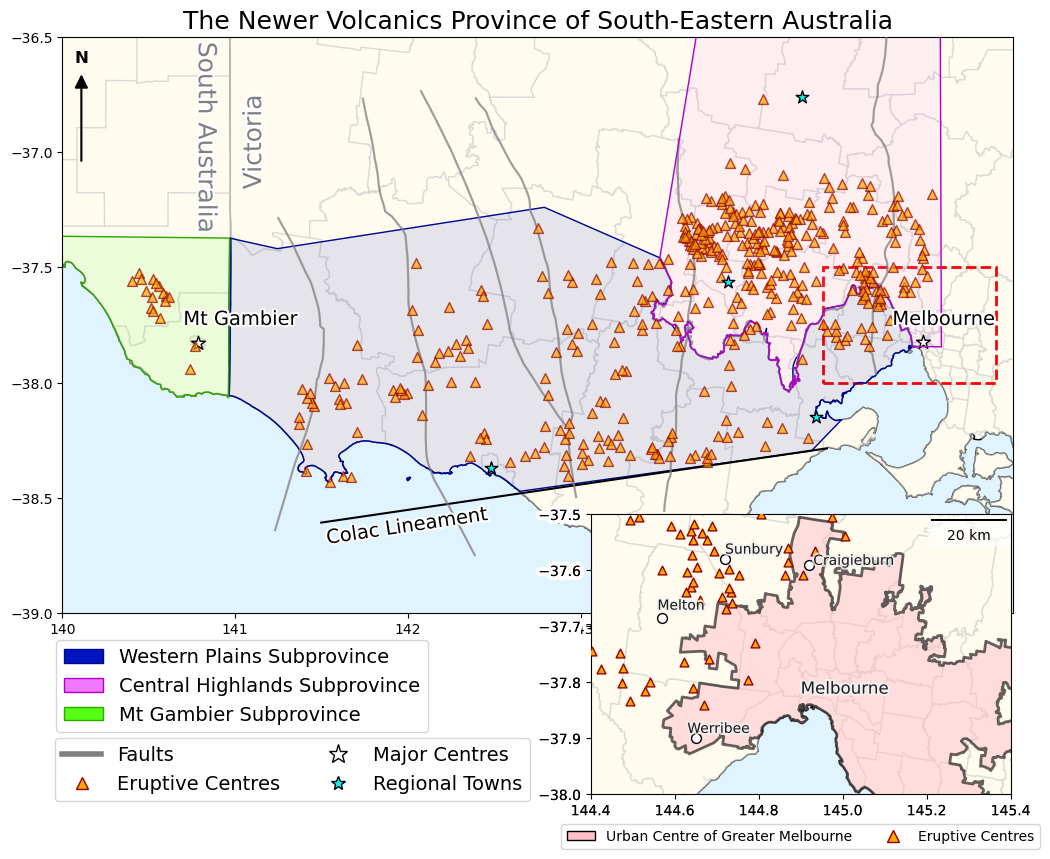

In [15]:
fig, (ax0) = plt.subplots(
    1, 1, 
    figsize=(12, 8),
    sharex=False,
    sharey=False,
    constrained_layout=True, 
    gridspec_kw={'wspace': 0.05}
)
plot_WiderNVP(ax0)

plt.savefig("DataMap_Outputs/MapInsertNVP.png", dpi=600, bbox_inches="tight",
    pad_inches=0.2
)